<a href="https://colab.research.google.com/github/slachitoff/DeepLearningMidTerm/blob/main/CS_GY_6953_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

from torchvision.transforms import ToPILImage

import numpy as np
import pickle

#Function to load a pickle file
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

#Function to load a CIFAR-10 batch file
def load_cifar10_batch(batch_filename):
    batch = unpickle(batch_filename)
    images = batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    labels = batch[b'labels']
    return images, labels

#Loaf images and labels from CIFAR-10 batch files
train_images1, train_labels1 = load_cifar10_batch('/content/data_batch_1')
train_images2, train_labels2 = load_cifar10_batch('/content/data_batch_2')
train_images3, train_labels3 = load_cifar10_batch('/content/data_batch_3')
train_images4, train_labels4 = load_cifar10_batch('/content/data_batch_4')
train_images5, train_labels5 = load_cifar10_batch('/content/data_batch_5')

#Combine all batch files into one array for images and labels
original_train_images = np.concatenate((train_images1, train_images2, train_images3, train_images4, train_images5))
original_train_labels = np.concatenate((train_labels1, train_labels2, train_labels3, train_labels4, train_labels5))

#Define transformations for training images
transform_train = transforms.Compose([
    ToPILImage(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=5),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

#Define transformations for testing and validation images
transform_test = transforms.Compose([
    ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

#Calculate the number of training and validation samples
num_train = int(0.95 * len(original_train_images))
num_val = len(original_train_images) - num_train

#Randomly shuffle the indices of the images
shuffled_indices = np.random.permutation(len(original_train_images))

#Split indices for training and validation sets
train_idx = shuffled_indices[:num_train]
val_idx = shuffled_indices[num_train:]

#Create subsets for validation/trianing images and labels based on shuffled incides
train_images_subset = original_train_images[train_idx]
val_images_subset = original_train_images[val_idx]
train_labels_subset = original_train_labels[train_idx]
val_labels_subset = original_train_labels[val_idx]

In [2]:
#Create a custom class for CIFAR-10 dataset
class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image, label = self.images[index], self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label

#Define the batch sizes for training and validation datasets
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_TEST = 100

#Create training and validation datasets using the CIFAR10Dataset class
train_dataset = CIFAR10Dataset(train_images_subset, train_labels_subset, transform=transform_train)
val_dataset = CIFAR10Dataset(val_images_subset, val_labels_subset, transform=transform_test)

#Create a DataLoader for the training set
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=2)

#Create a DataLoader for the validation set
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False, num_workers=2)

In [3]:
#PreActBlock definition from https://github.com/kuangliu/pytorch-cifar/blob/master/models/preact_resnet.py
#Modified to incorporate dropout layers
class PreActBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, dropout_rate=0.0):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.dropout = nn.Dropout(dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.dropout(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        out = F.relu(out)
        return out

#PreResNet definition from https://github.com/kuangliu/pytorch-cifar/blob/master/models/preact_resnet.py
#Modified to incorporate dropout layers
class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, dropout_rate=0.0):
        super(PreActResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, dropout_rate=dropout_rate)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, dropout_rate):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, dropout_rate))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
#Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Initialize an instance of the PreActResNet model consisting of two blocks in the first stage, with 1 block in each of the subsequent stages
#Used to reduce the overall parameter count to <5 million
model = PreActResNet(PreActBlock, [2, 1, 1, 1], num_classes=10, dropout_rate=0.0)

#Uncomment the following code to load a pretrained model from a file:

# state_dict = torch.load('/content/model.pt')
# model.load_state_dict(state_dict)

#Move the model to the designated device
model.to(device)

PreActResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (dropout): Dropout(p=0.0, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (shortcut): Sequential()
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (dropout): Dropout(p=0.0, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3)

In [5]:
from torchsummary import summary

#Display a summary of the model architecture, including the number of parameters, given an input from the CIFAR-10 dataset
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
           Dropout-4           [-1, 64, 32, 32]               0
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]          36,864
       PreActBlock-7           [-1, 64, 32, 32]               0
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]          36,864
          Dropout-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
           Conv2d-12           [-1, 64, 32, 32]          36,864
      PreActBlock-13           [-1, 64, 32, 32]               0
      BatchNorm2d-14           [-1, 64,

In [6]:
import time
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

#Define the training process for a single epoch
def train_epoch(model, optimizer, data_loader, criterion, device, loss_history, accuracy_history):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for data, target in data_loader:
        data, target = data.to(device), target.to(device) #Move the data to the designated device
        optimizer.zero_grad() #Erase any gradient from previous iterations
        output = model(data) #Compute the output of the model
        loss = criterion(output, target) #Calculate the loss
        loss.backward() #Perform backpropagation
        optimizer.step() #Update model weights
        scheduler.step() #Modify the learning ratte based on the scheduler

        total_loss += loss.item() #Accumulate total loss from the batch
        _, predicted = torch.max(output.data, 1) #Determine the predicted class
        total += target.size(0) #Count total samples processed
        correct += (predicted == target).sum().item() #Count correct predictions

    avg_loss = total_loss / len(data_loader) #Calcualte average loss over the entire epoch
    accuracy = 100. * correct / total #Calculate percentage of correct predictions
    print(f'Training: Average Loss: {avg_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.0f}%)')
    loss_history.append(avg_loss) #Store the average loss
    accuracy_history.append(accuracy) #Store the accuracy

#Define the validation process
def validate(model, data_loader, criterion, device, loss_history, accuracy_history):
    model.eval() #Set model to evaluation mode
    val_loss = 0
    correct = 0
    with torch.no_grad(): #Disable gradient calculations
        for data, target in data_loader:
            data, target = data.to(device), target.to(device) #Move the data to the designated device
            output = model(data) #Compute the output of the model
            loss = criterion(output, target) #Calculate the loss
            val_loss += loss.item() #Accumulate total loss from the batch
            _, predicted = torch.max(output.data, 1) #Determine the predicted class
            correct += (predicted == target).sum().item() #Count correct predictions

    avg_loss = val_loss / len(data_loader) #Calcualte average validation loss
    accuracy = 100. * correct / len(data_loader.dataset) #Calculate validation accuracy
    print(f'Validation: Average Loss: {avg_loss:.4f}, Accuracy: {correct}/{len(data_loader.dataset)} ({accuracy:.0f}%)')
    loss_history.append(avg_loss) #Store average validation loss
    accuracy_history.append(accuracy) #Store validation accuracy

#Set up training parameters
N_EPOCHS = 400
optimizer = AdamW(model.parameters(), lr=0.01, weight_decay=0.005)
criterion = nn.CrossEntropyLoss()
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=N_EPOCHS)

#Initialize storage for tracking progress
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

start_time = time.time() #Record training start time

#Define training loop
for epoch in range(1, N_EPOCHS + 1):
    print(f'\nEpoch {epoch}/{N_EPOCHS}')
    train_epoch(model, optimizer, train_loader, criterion, device, train_loss_history, train_accuracy_history) #Train for a single epoch
    validate(model, val_loader, criterion, device, val_loss_history, val_accuracy_history) #Perform validation

#Calculate and print total training time
execution_time = time.time() - start_time
print(f'\nExecution time: {execution_time:.2f} seconds')


Epoch 1/400


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: Average Loss: 1.7166, Accuracy: 17283/47500 (36%)
Validation: Average Loss: 1.2202, Accuracy: 1400/2500 (56%)

Epoch 2/400
Training: Average Loss: 1.2608, Accuracy: 26108/47500 (55%)
Validation: Average Loss: 0.9232, Accuracy: 1692/2500 (68%)

Epoch 3/400
Training: Average Loss: 1.0564, Accuracy: 29860/47500 (63%)
Validation: Average Loss: 0.7653, Accuracy: 1837/2500 (73%)

Epoch 4/400
Training: Average Loss: 0.9129, Accuracy: 32306/47500 (68%)
Validation: Average Loss: 0.6882, Accuracy: 1891/2500 (76%)

Epoch 5/400
Training: Average Loss: 0.8207, Accuracy: 33875/47500 (71%)
Validation: Average Loss: 0.6112, Accuracy: 1983/2500 (79%)

Epoch 6/400
Training: Average Loss: 0.7532, Accuracy: 35006/47500 (74%)
Validation: Average Loss: 0.5568, Accuracy: 2024/2500 (81%)

Epoch 7/400
Training: Average Loss: 0.7131, Accuracy: 35775/47500 (75%)
Validation: Average Loss: 0.5180, Accuracy: 2059/2500 (82%)

Epoch 8/400
Training: Average Loss: 0.6731, Accuracy: 36387/47500 (77%)
Validatio

In [7]:
# Save the trained model parameters to a file called "model.pt"
torch.save(model.state_dict(), 'model.pt')

In [8]:
from PIL import Image

#Load the test batch from the specified loaction
test_images, test_labels = load_cifar10_batch('/content/test_batch')

#Define transformations for the test images
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

#Apply transformations to each image in the test set and stack them into a tensor
test_images_tensor = torch.stack([transform_test(Image.fromarray(img)) for img in test_images])

#Convert test labels into a tensor
test_labels_tensor = torch.tensor(test_labels)

#Create a TensorDataset to manage image-label pairs
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

#DataLoader for the test batch
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


model.eval() #Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device) #Send images to the device
        labels = labels.to(device) #Send labels to the device

        outputs = model(images) #Compute model outputs
        _, predicted = torch.max(outputs.data, 1) #Predict the class
        total += labels.size(0) #Increase total count
        correct += (predicted == labels).sum().item() #Count correct predictions

test_accuracy = 100.0 * correct / total
print(f'Accuracy on the test set: {test_accuracy}%') #Print test accuracy


Accuracy on the test set: 95.45%


In [9]:
import pandas as pd
from PIL import Image

#Define function to load data from a pickle file
def load_pickle_file(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data


unlabeled_test_data = load_pickle_file('/content/cifar_test_nolabels.pkl') # Load unlabled test data from the pickle file
num_images = unlabeled_test_data[b'data'].shape[0] #Store the number of images
test_images = unlabeled_test_data[b'data'].reshape((num_images, 3, 32, 32)).transpose((0, 2, 3, 1)) #Reshape and transpose test set

transformed_images = [transform_test(Image.fromarray(img)) for img in test_images] #Apply previously defined transformations

predictions = [] #Store predictions

#Perform predictions without updating model weights
with torch.no_grad():
    for i, img in enumerate(transformed_images):
        img = img.unsqueeze(0).to(device) #Add a batch dimension and send the image to a device
        outputs = model(img) #Get output from model
        _, predicted = torch.max(outputs, 1) #Predict the class
        predictions.append((i, predicted.item())) #Append image index and predicted class


df_predictions = pd.DataFrame(predictions, columns=["ID", "Labels"]) #Create a DataFrame from the "predictions" list
df_predictions.to_csv('/content/predicted_labels.csv', index=False) #Svae predictions to a CSV file called "predicted_labels"


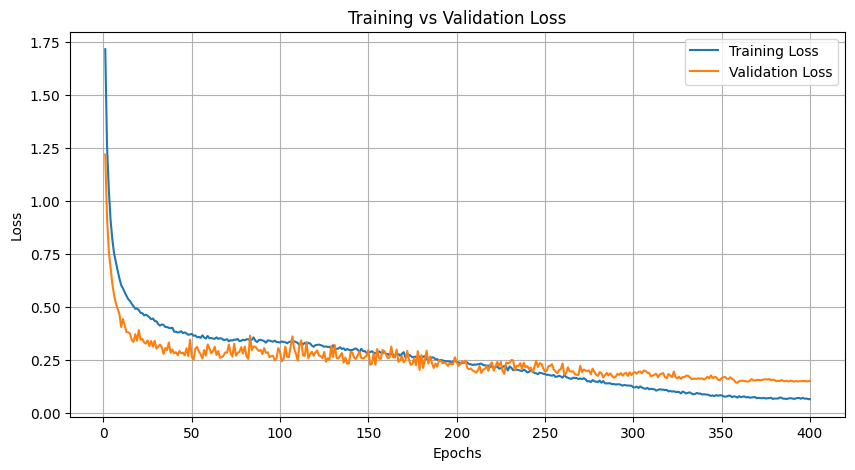

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, N_EPOCHS + 1)

#Generate a plot of the training loss against the valiadtion loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_history, label='Training Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()